# Seating Plan Shuffle

This notebook performs a randomized seating arrangement. See [this blog post](http://multithreaded.stitchfix.com/blog/2016/08/16/shuffling-seats/) for motivations.

### Libraries and Utility Functions

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import division
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import lines, patches
from IPython.display import display
from time import time
from copy import deepcopy


pd.set_option('display.max_rows', 500)

ALGORITHMS = "Algorithms"
MAX_SEED = 2**32 - 1


def merge_dicts(*dict_args):
    '''
    Given any number of dicts, merge into a new dict.
    Precedence goes to key value pairs in latter dicts.
    '''
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result


def get_seed(audience_seed=0, usetime=True):
    """
    Return a 32-bit random seed, optionally partially-seeded by audience input.
    """
    time_microseconds = int(1e6 * time()) if usetime else 0
    seed1 = audience_seed + time_microseconds % MAX_SEED  # time-based random seed
    np.random.seed(seed1)
    return np.random.randint(MAX_SEED)

### Random Seed

This section is best performed with fanfare on a big screen surrounded by the team.

In [2]:
print "Please provide a seed value"
input_seed = input()
random_seed = get_seed(audience_seed=input_seed, usetime=True)
print "random seed is: {rs}".format(rs=random_seed)

Please provide a seed value
25
random seed is: 4255252154


### The Random Shuffle

In [3]:
np.random.seed(random_seed)
team = pd.read_csv("team.csv")
fixed_seats = pd.read_csv("fixed_seats.csv")
combined = pd.merge(team, fixed_seats, how='outer')
combined['fixed'] = combined.fixed.fillna(False)
combined['fullname'] = combined['first'] + ' ' + combined['last']
combined.loc[~combined.needs_seat, 'seat_number'] = np.nan
combined.loc[~combined.needs_seat, 'fixed'] = False
print "Fixed seats:"
display(combined[combined.fixed].sort_values('seat_number'))
print "No seat:"
display(combined[combined.needs_seat == False])
needs_seats = combined[combined.needs_seat]

all_seats = range(26, 84) + range(85, 99) + range(103, 109)
print "Number of available seats:", len(all_seats)
print "Number of needed seats:   ", needs_seats.shape[0]
print ""
print "All seat numbers:"
print all_seats

Fixed seats:


,first,last,needs_seat,original_seat,seat_number,fixed,fullname
10,First11,Last11,True,36,42.0,True,First11 Last11
22,First23,Last23,True,48,43.0,True,First23 Last23
34,First35,Last35,True,60,44.0,True,First35 Last35
46,First47,Last47,True,72,45.0,True,First47 Last47


No seat:


,first,last,needs_seat,original_seat,seat_number,fixed,fullname
78,First79,Last79,False,-1,NaN,False,First79 Last79
79,First80,Last80,False,-1,NaN,False,First80 Last80


Number of available seats: 78
Number of needed seats:    78

All seat numbers:
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 103, 104, 105, 106, 107, 108]


In [4]:
# Set random seed and choose which people to move
movable_people = needs_seats[~needs_seats.fixed]
fixed_people   = needs_seats[ needs_seats.fixed]
fixed_seat_nums = fixed_people.seat_number.astype(int).tolist()
available_seats = np.array([ss for ss in all_seats if ss not in fixed_seat_nums])
orig_available_seats = deepcopy(available_seats)
np.random.shuffle(available_seats)  # The magic happens here!
fixed = {ss:nn for ss,nn in zip(fixed_people.seat_number.astype(int), fixed_people.fullname)}
shuffled = {ss:nn for ss,nn in zip(available_seats, movable_people.fullname)}
plan = merge_dicts(fixed, shuffled)
print "First few seat assignments..."
display(pd.DataFrame(plan.items(), columns=['seat_number', 'fullname']).head())

First few seat assignments...


,seat_number,fullname
0,26,First52 Last52
1,27,First78 Last78
2,28,First5 Last5
3,29,First75 Last75
4,30,First59 Last59


### Mapping the Results

In [5]:
# set up visualization
columns = np.array([3, 7, 7, 7, 7, 4, 4])

def make_coords(all_seat_numbers, columns,
                cols_before_spacer=2, spacer_width=4):
    """
    Generates the coordinates for plotting the seats
    """
    cols_dupd = [c for c in columns for _ in range(2)]
    xx = np.arange(0, 3*len(columns), 3)
    xx[2:] += spacer_width
    xx = np.unique(list(xx) + list(xx + 1))
    x_columns = {x:c for x, c in zip(xx, cols_dupd)}

    # set up coords
    xx_ndx = len(xx) - 1
    xx_coord = xx[xx_ndx]
    yy_coord = 1 + columns[-1]
    y_decreasing = True
    coords = {}
    y_min = np.inf
    y_max = -np.inf
    for num in all_seat_numbers:  # snake through the seats
        if y_decreasing:
            yy_coord -= 1
        else:
            yy_coord += 1
        if yy_coord < 1:  # shift left and stay at y=1
            xx_ndx -= 1
            xx_coord = xx[xx_ndx]
            yy_coord = 1
            y_decreasing = not y_decreasing
        elif yy_coord > x_columns[xx_coord]:
            xx_ndx -= 1
            xx_coord = xx[xx_ndx]
            yy_coord = x_columns[xx_coord]
            y_decreasing = not y_decreasing
        coords[num] = xx_coord, yy_coord
        if yy_coord < y_min:
            y_min = yy_coord
        if yy_coord > y_max:
            y_max = yy_coord
    return coords, xx, y_min, y_max

coords, xx, y_min, y_max = make_coords(all_seats, columns)

# set up functions for visualization
def plot_centered_square(center_xy, block_size, color='y', alpha=0.5):
    """
    Makes a single square centered on a coordinate
    """
    lower_left_xy = center_xy - np.array([block_size/2., block_size/2.])
    plt.gca().add_patch(plt.Rectangle(lower_left_xy, block_size, block_size,
                                      color=color, alpha=alpha, zorder=-3))

def plot_plan(coords_dict, plan, block_size=0.9,
              figsize=(16, 8),
              color='y', alpha=0.5,
              delta=0.2, max_name_length=10, scramble=False):
    """
    Plots the seating plan, optionally scrambing the names.
    """
    plt.figure(figsize=figsize)
    axis = plt.axis([xx.min()-block_size/2.-delta,
                     xx.max()+block_size/2.+delta,
                     y_min-block_size/2.-delta,
                     y_max+block_size/2.+delta])
    for seat_num, coord in coords_dict.items():
        plot_centered_square(coord, block_size, color=color, alpha=alpha)
        name = plan[seat_num]
        if name != '':
            if name == ALGORITHMS:
                name = 'Algorithms (Empty)'
            name_split = [nn[:max_name_length] for nn in name.split()]
            if scramble and name != 'Algorithms (Empty)':
                for ii, firstlast_name in enumerate(name_split):
                    firstlast_name += 'aslktyqwoi'
                    new_name = []
                    for jj, cc in enumerate(firstlast_name):
                        if jj == 0:
                            new_name.append(chr(np.mod(ord(cc)-ord('A') + 5, 26) + ord('A')))
                        else:
                            new_name.append(chr(np.mod(ord(cc)-ord('a') + 13, 26) + ord('a')))
                    name_split[ii] = ''.join(new_name)
                name_split = [nn[:max_name_length] for nn in name_split]
            name = str(seat_num) + '\n' + '\n'.join(name_split)
        else:
            name = str(seat_num)
        plt.text(coord[0], coord[1], name,
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=8,
                 fontweight='bold')
    _ = plt.axis(axis)
    plt.axis('off')

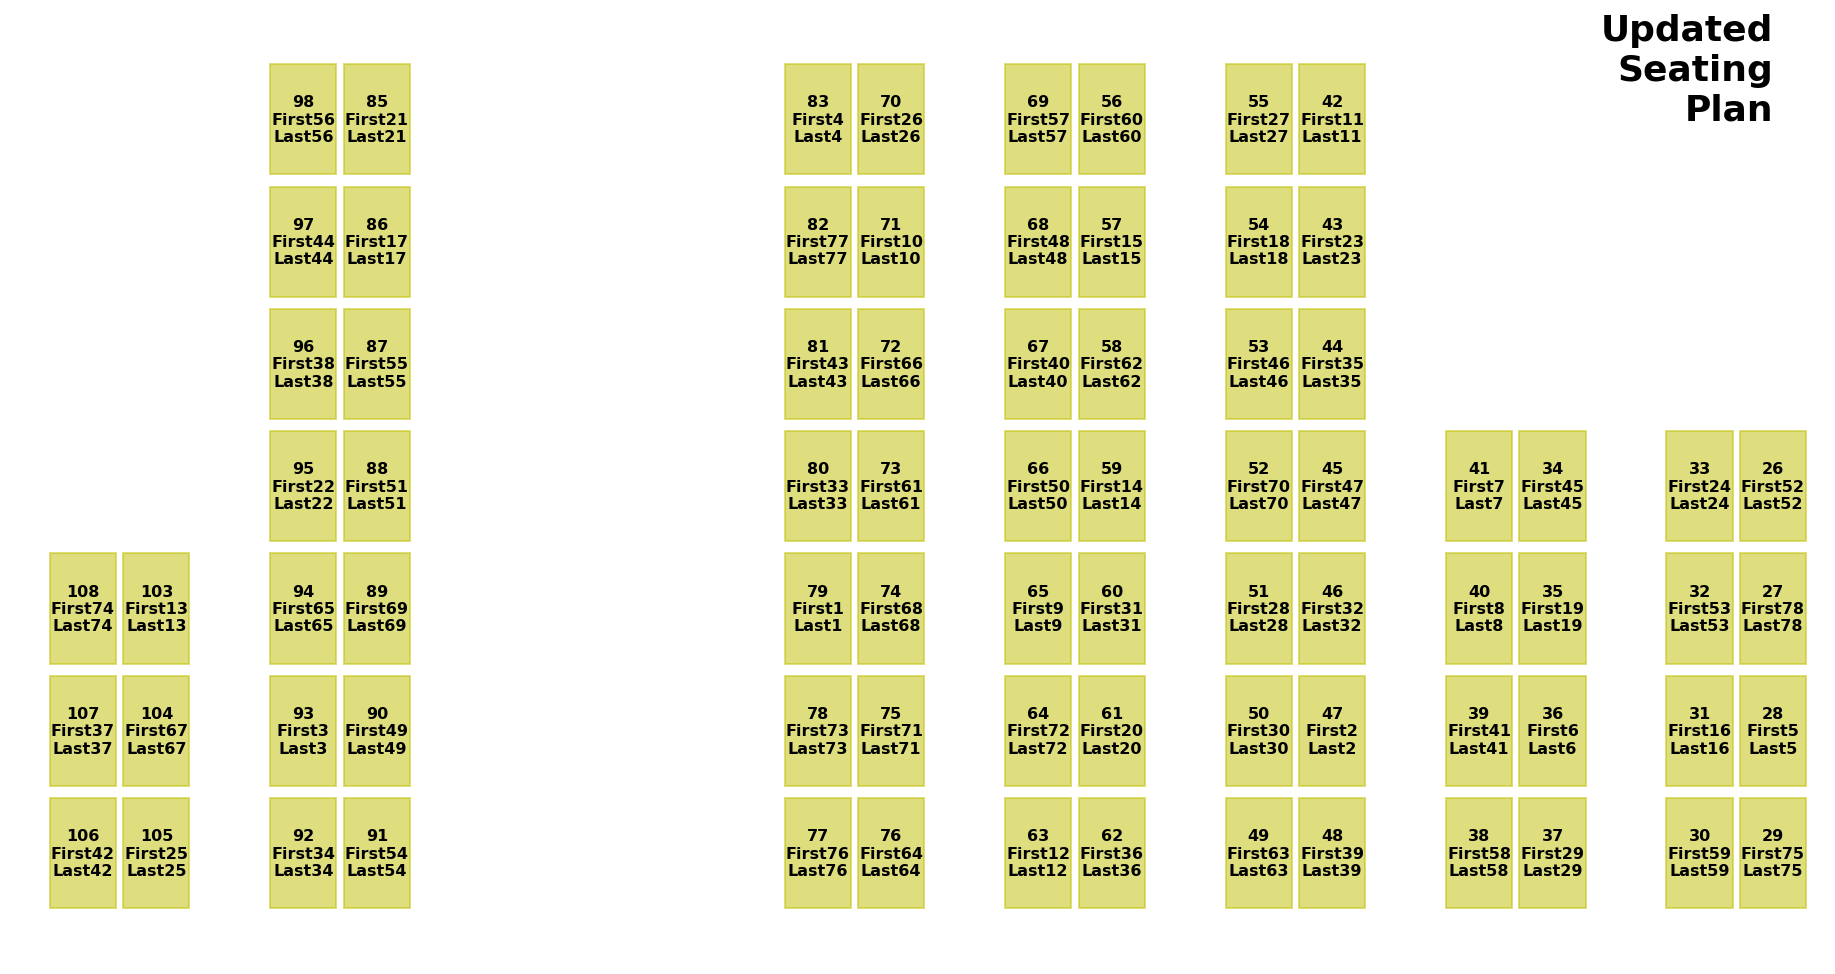

In [6]:
plot_plan(coords, plan, scramble=False, max_name_length=7)
plt.text(xx[-1], columns.max(), 'Updated\nSeating\nPlan',
         fontsize=18, fontweight='bold',
         horizontalalignment='right')
filename = "updated_seating_plan_randseed_{rs}.pdf".format(rs=random_seed)
plt.savefig(filename)

#with_blanks = True
with_blanks = False
if with_blanks:
    plot_plan(coords, plan, scramble=False, max_name_length=0)
    plt.text(xx[-1], columns.max(), 'Seating\nPlan',
             fontsize=18, fontweight='bold',
             horizontalalignment='right')
    plt.savefig("seating_plan_blanks.pdf")

In [7]:
seating_final = pd.DataFrame([(k, v) for k, v in plan.items()],
                             columns=['seat_number', 'name'])
seating_final.sort_values(by='seat_number', inplace=True)
seating_final.index = range(seating_final.shape[0])
seating_final.to_csv('updated_seat_plan_randseed_{rs}.csv'.format(rs=random_seed), index=False)
print "First few seat assignments..."
display(seating_final.head())

First few seat assignments...


,seat_number,name
0,26,First52 Last52
1,27,First78 Last78
2,28,First5 Last5
3,29,First75 Last75
4,30,First59 Last59


### Find Cycles

Potentially handy for maximizing the efficiency of the move, but also just 

In [8]:
def find_cycles(mapping):
    """
    Returns a list of disjoint cycles into which the permutation factors.
    """
    cycles = []
    seatnums_so_far = set()
    for old_seatnum in mapping.keys():
        if old_seatnum in seatnums_so_far:
            continue
        cycle = []
        while True:
            seatnums_so_far.add(old_seatnum)
            cycle.append(old_seatnum)
            new_seatnum = mapping[old_seatnum]
            if new_seatnum in cycle:  # cycle is complete
                cycles.append(cycle)
                break
            else:
                old_seatnum = new_seatnum
    return sorted(cycles, key=len)


def add_arrow_to_line2D(axes, line, arrow_locs=[0.2, 0.4, 0.6, 0.8],
                        arrowstyle='-|>', arrowsize=3, transform=None):
    """
    (From http://stackoverflow.com/questions/26911898/matplotlib-curve-with-arrow-ticks)
    
    Add arrows to a matplotlib.lines.Line2D at selected locations.

    Parameters:
    -----------
    axes: 
    line: list of 1 Line2D obbject as returned by plot command
    arrow_locs: list of locations where to insert arrows, % of total length
    arrowstyle: style of the arrow
    arrowsize: size of the arrow
    transform: a matplotlib transform instance, default to data coordinates

    Returns:
    --------
    arrows: list of arrows
    """
    if (not(isinstance(line, list)) or not(isinstance(line[0], 
                                           lines.Line2D))):
        raise ValueError("expected a matplotlib.lines.Line2D object")
    xx, yy = line[0].get_xdata(), line[0].get_ydata()

    arrow_kw = dict(arrowstyle=arrowstyle, mutation_scale=10 * arrowsize)

    color = line[0].get_color()
    use_multicolor_lines = isinstance(color, np.ndarray)
    if use_multicolor_lines:
        raise NotImplementedError("multicolor lines not supported")
    else:
        arrow_kw['color'] = color

    linewidth = line[0].get_linewidth()
    if isinstance(linewidth, np.ndarray):
        raise NotImplementedError("multiwidth lines not supported")
    else:
        arrow_kw['linewidth'] = linewidth

    if transform is None:
        transform = axes.transData

    arrows = []
    for loc in arrow_locs:
        ss = np.cumsum(np.sqrt(np.diff(xx) ** 2 + np.diff(yy) ** 2))
        nn = np.searchsorted(ss, ss[-1] * loc)
        arrow_tail = (xx[nn], yy[nn])
        arrow_head = (np.mean(xx[nn:nn + 2]), np.mean(yy[nn:nn + 2]))
        pp = patches.FancyArrowPatch(
            arrow_tail, arrow_head, transform=transform,
            **arrow_kw)
        axes.add_patch(pp)
        arrows.append(pp)
    return arrows


def visualize_cycles(cycles, circle_nn=360,
                     default_circle_angle_fraction=0.99, circle_r_fraction=0.97):
    """
    Displays cycles with arrows
    """
    max_cycle_length = max([len(cc) for cc in cycles])
    fontsize = 12 * 70 / max_cycle_length
    figsize = 12 * (12 / fontsize)
    for ii, cycle in enumerate(cycles):
        fig, ax = plt.subplots(figsize=(figsize, figsize))
        nn = len(cycle)
        dphi = 2 * np.pi / nn
        phi = (np.pi / 2) - np.arange(0, 2*np.pi, dphi)
        xx = np.cos(phi) if nn > 1 else [0]
        yy = np.sin(phi) if nn > 1 else [0]
        for jj, seatnum in enumerate(cycle):
            thisx = xx[jj]
            thisy = yy[jj]
            plt.text(thisx, thisy, "{sn}".format(sn=seatnum), fontsize=12, zorder=3, alpha=0.5,
                     horizontalalignment='center', verticalalignment='center')
        _ = plt.xlim(-1.3, 1.3)
        _ = plt.ylim(-1.3, 1.3)
        plt.axis('off')
        plt.title("cycle #{num}".format(num=ii), fontsize=18)
        # Add arc arrows
        if nn > 1:
            circle_dphi = 2 * np.pi / circle_nn
            arrowsize = 3 * np.sqrt(80 / nn)
            circle_angle_fraction = default_circle_angle_fraction - arrowsize / 300
            max_angle = 2 * np.pi * circle_angle_fraction
            circle_phi = (np.pi / 2) - np.arange(0, max_angle, circle_dphi)
            circle_x = np.cos(circle_phi) * circle_r_fraction
            circle_y = np.sin(circle_phi) * circle_r_fraction
            line = plt.plot(circle_x, circle_y, color='b', zorder=1)
            add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0., 1., nn+1), arrowsize=arrowsize)

(39, 59, 92, 72, 45, 61, 62, 107, 82, 69, 97, 75, 66)
(27, 47, 95, 89, 49, 33, 40, 57, 46, 85, 30, 28, 93, 104, 108)
(26, 79, 91, 94, 74, 90, 76, 88, 58, 80, 87, 73, 68, 81, 98, 64, 48, 43, 54, 37, 63, 96, 52, 55, 50, 105, 29, 83, 38, 103, 78, 32, 41, 31, 36, 42, 86, 56, 60, 44, 35, 71, 53, 51, 70, 34, 65, 67, 106, 77)


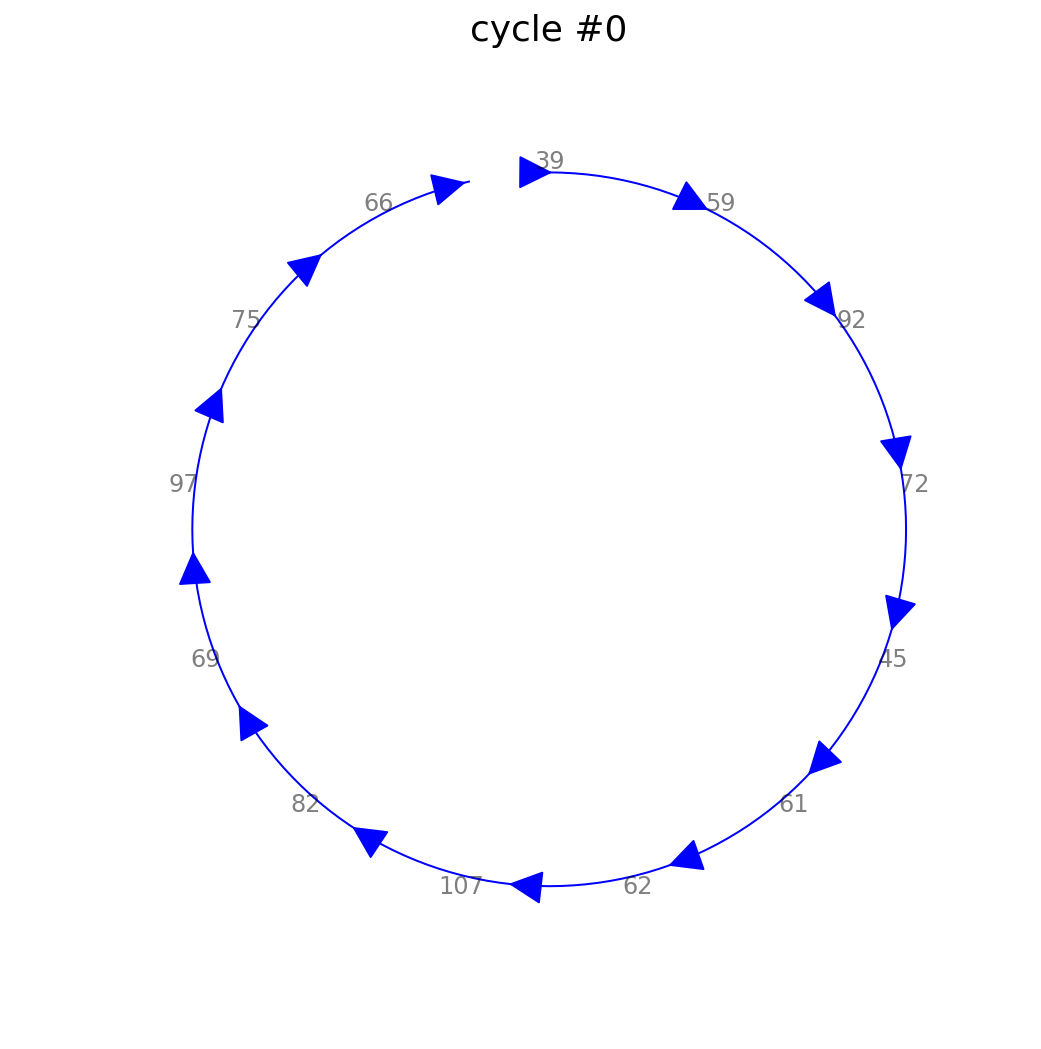

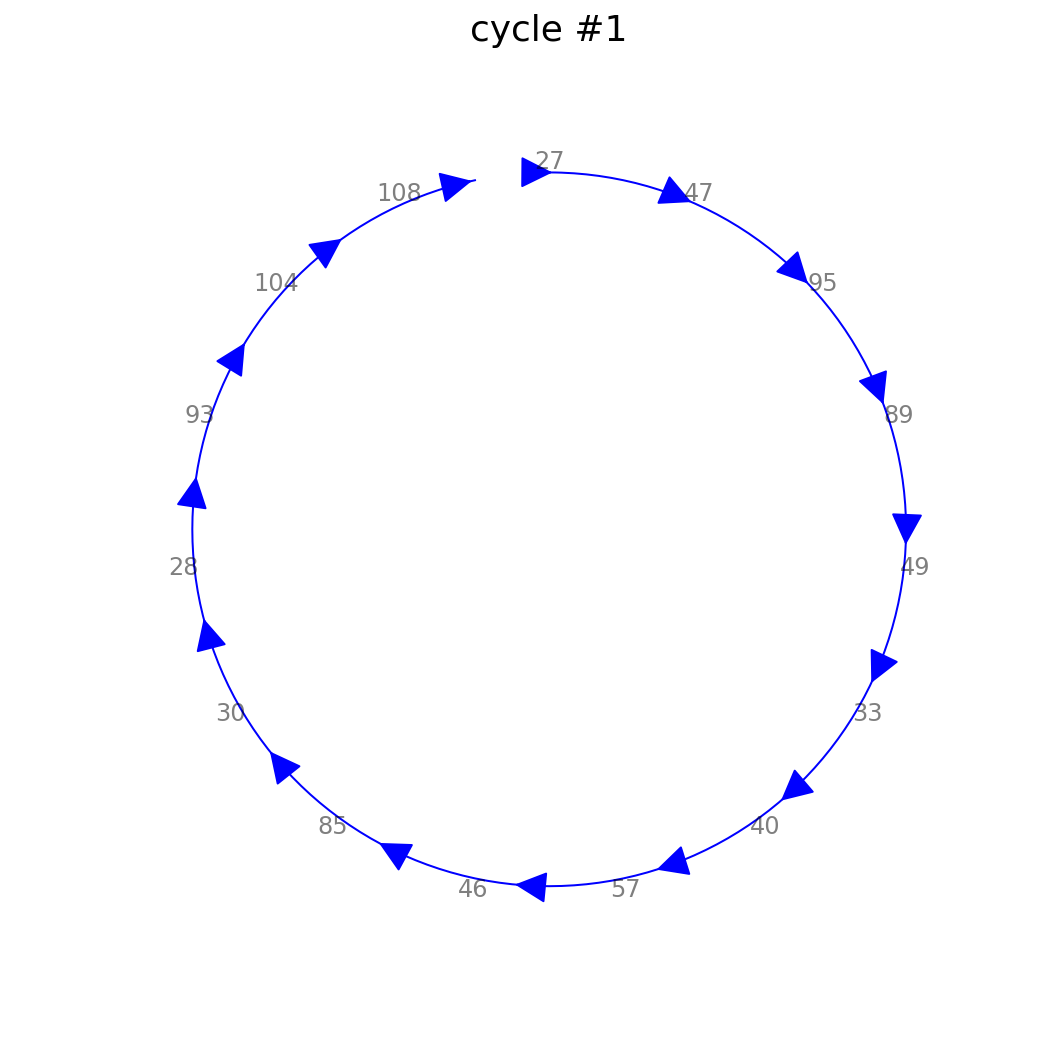

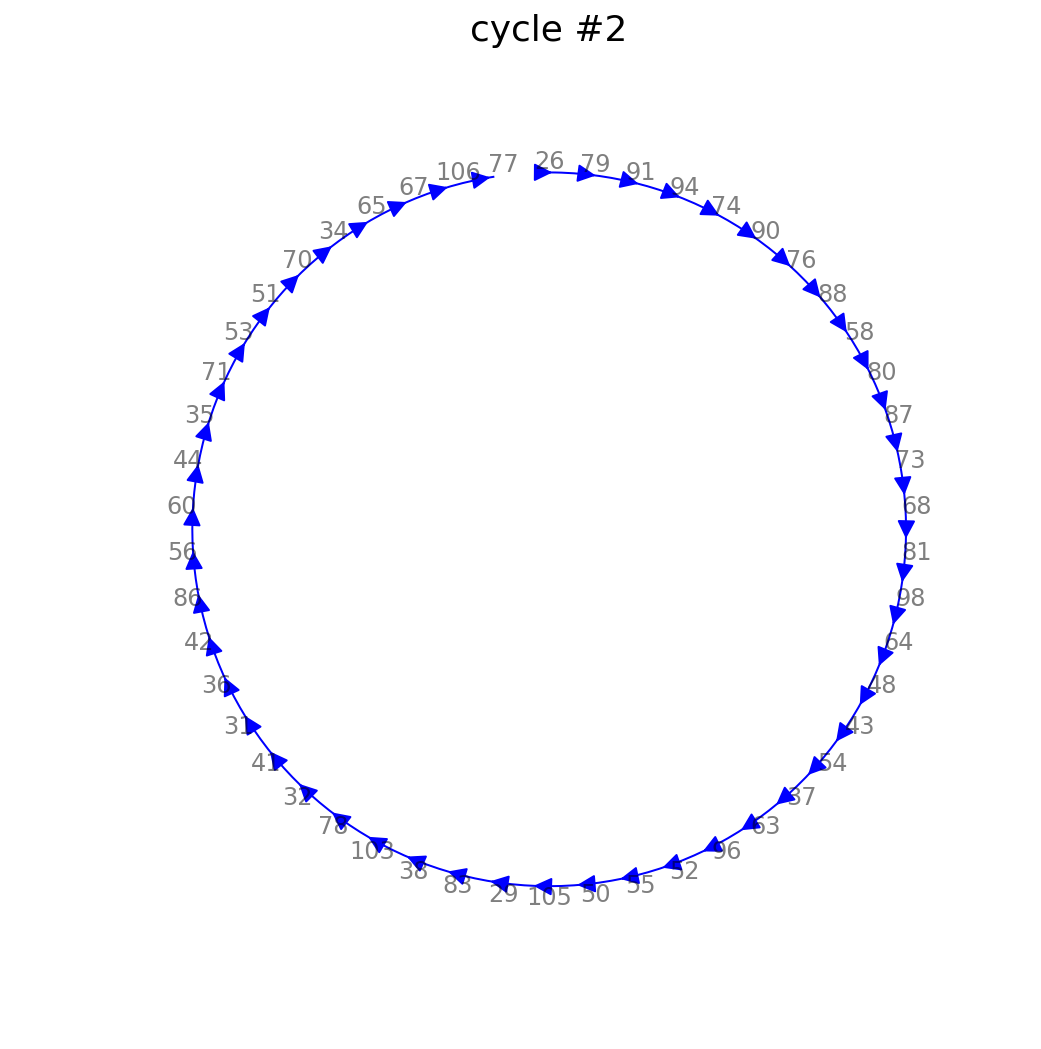

In [9]:
# This only works if the reseating is a pure permutation
combined_needsseat = combined[combined.needs_seat]
orig_seats = {seatnum: name for seatnum, name in zip(combined_needsseat.original_seat,
                                                     combined_needsseat.fullname)}
plan_value_to_key = {vv: kk for kk, vv in plan.items()}
mapping = {orig_seat: plan_value_to_key[name] for orig_seat, name in orig_seats.items()}
cycles = find_cycles(mapping)
for cycle in cycles:
    print str(tuple(cycle))
visualize_cycles(cycles)